In [1]:
import os
import json
import uuid
from typing import List, Tuple, Literal, Annotated

from dotenv import load_dotenv
from langchain.chains.summarize.map_reduce_prompt import prompt_template
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage
# from langchain_core.pydantic_v1 import BaseModel
from pydantic import BaseModel
# from langgraph.graph import StateGraph, END, START
# from langgraph.checkpoint.memory import MemorySaver
# from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
# import gradio as gr

from gen_ai_hub.proxy.langchain.openai import ChatOpenAI
from gen_ai_hub.proxy.core.proxy_clients import get_proxy_client
from win32comext.adsi.demos.scp import verbose

proxy_client = get_proxy_client("gen-ai-hub")

load_dotenv()
aicore_home = os.getenv("AICORE_HOME")
profile = os.getenv("AICORE_PROFILE", "default")
config_path = os.path.join(aicore_home, f"config.json")
from ai_core_sdk.ai_core_v2_client import AICoreV2Client

# 구성 파일에서 값 읽어오기
with open(config_path, "r") as config_file:
    config = json.load(config_file)

# 클라이언트 초기화
ai_core_client = AICoreV2Client(
    base_url=config["AICORE_BASE_URL"],
    auth_url=config["AICORE_AUTH_URL"],
    client_id=config["AICORE_CLIENT_ID"],
    client_secret=config["AICORE_CLIENT_SECRET"],
)

print("AI Core client initialized successfully!")
llm = ChatOpenAI(proxy_model_name='gpt-4o-mini', proxy_client=proxy_client)
model = ChatOpenAI(proxy_model_name='gpt-4o-mini', proxy_client=proxy_client)
from langchain_core.prompts import PromptTemplate


AI Core client initialized successfully!


In [2]:
from langchain_core.prompts import ChatPromptTemplate

from langchain_openai import ChatOpenAI

# Assume OPENAI_API_KEY is set
prompt = ChatPromptTemplate.from_template("Tell me a joke about {topic}")
# model = ChatOpenAI()

# This creates a RunnableSequence instance
chain = prompt | model
response = chain.invoke({"topic": "cats"})
print(response.content)

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


In [10]:
template02 = """ Based on the following information, summarize all the working hours and calculate compensatory leave hours. 
    Follow these steps very carefully:
        
    1. Set fixed Over Time standards:
       Weekday fixed Over Time = 30 hours
       Weekend fixed Over Time = 10 hours
    
    2. Calculate weekday compensatory leave:
       a. Excess weekday overtime = MAX(0, weekday_overtime - 30)
       b-1. no exceeding the weekday fixed over time, Weekday compensatory leave = (Excess weekday overtime × 1.5) + (Weekday night work × 0.5)
       b-2. exceeding the weekday fixed over time, Weekday compensatory leave = (Excess weekday overtime × 1.5) + (Weekday night work × 2)
    
    3. Calculate weekend compensatory leave:
       a. Excess weekend overtime = MAX(0, weekend_overtime - 10)
       b-1. If no exceeding the weekend fixed over time, Weekend compensatory leave = (excess weekend overtime × 1.5) + (Weekend night work × 0.5) 
       b-2. If exceeding the weekend fixed over time, Weekend compensatory leave = (excess weekend overtime × 1.5) + (Weekend night work × 2)
    
    4. Calculate total compensatory leave:
       Total compensatory leave hours = Weekday compensatory leave + Weekend compensatory leave
    
    5. Round all calculated hours to two decimal places.provide a clear and concise summary of the overtime hours they want to calculate for compensatory leave.
    
    output format summary as follows:
    <summary>
    === 보상 휴가 시간 계산 결과 ===
    평일 보상 휴가 시간: 
    주말/휴일 보상 휴가 시간: 
    총 보상 휴가 시간: 
    주말/휴일 근무 시간에 "대체 휴일"을 적용한 경우, 주말/휴일 보상 시간은 위의 계산 결과와 다를 수 있습니다.
    </summary>
    
    {reqs}

"""
prompt = ChatPromptTemplate.from_template(
    template=template02
)
reqs = "평일 연장근무는 몇시간 인가요? 10시간입니다. 평일 야간근무는 0시간 입니다. 주말 연장근무는 30분이구요. 주말 야간근무는 4시간입니다. 보상휴가를 시간을 계산해라 "
chain1 = prompt | llm  
response=chain1.invoke({"reqs": reqs})
print(response.content)


To calculate the compensatory leave hours based on the provided information, we will follow the outlined steps.

1. **Fixed Over Time Standards:**
   - Weekday fixed Over Time: 30 hours
   - Weekend fixed Over Time: 10 hours

2. **Given Data:**
   - Weekday overtime: 10 hours
   - Weekday night work: 0 hours
   - Weekend overtime: 0.5 hours (30 minutes)
   - Weekend night work: 4 hours

3. **Calculate Weekday Compensatory Leave:**
   a. Excess weekday overtime = MAX(0, weekday_overtime - 30)
   - Excess weekday overtime = MAX(0, 10 - 30) = 0 hours (no excess)

   b. Since there is no exceeding the weekday fixed overtime, we use the first formula for compensatory leave:
   - Weekday compensatory leave = (0 × 1.5) + (0 × 0.5) = 0 hours

4. **Calculate Weekend Compensatory Leave:**
   a. Excess weekend overtime = MAX(0, weekend_overtime - 10)
   - Excess weekend overtime = MAX(0, 0.5 - 10) = 0 hours (no excess)

   b. Since there is no exceeding the weekend fixed overtime, we use the firs

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.tools import tool

class WorkHoursInputSchema(BaseModel):
    """calculate compensatory leave hours"""
    weekday_overtime: float = Field(description=" Total over time of weekdays of a month: 월간 평일 총 연장 근무 시간. (예) 1시간=1.00, 1시간 30분=1.50, 20분=0.33, 0분=0 등. ")
    weekday_night: float = Field(description="Total night work time of weekdays of a month : 월간 평일 총 야간 근무 시간. (예) 1시간=1.00, 1시간 30분=1.50, 20분=0.33, 0분=0 등. ")
    weekend_overtime: float = Field(description="Total over time of weekends of a month: 월간 주말 총 연장 근무 시간. (예) 2시간=2.00, 1시간 30분=1.50, 20분=0.33, 0분=0 등.")
    weekend_night: float = Field(description="Total night work time of weekends of a month : 월간 주말 총 야간 근무 시간. (예) 2시간=2.00, 1시간 30분=1.50, 20분=0.33, 0분=0 등.")

@tool("calculator_tool", args_schema=WorkHoursInputSchema)
def calculator(weekday_overtime: float, weekday_night: float, weekend_overtime: float, weekend_night:float ) -> dict[str, float]:
    
    return weekday_night + weekday_overtime + weekend_overtime + weekend_night


In [35]:
from pydantic import BaseModel, Field
from langchain_core.tools import tool

class TimeCriteria(BaseModel):
    """calculate compensatory leave hours"""
    weekday_overtime: float = Field(description=" Total over time of weekdays of a month: 월간 평일 총 연장 근무 시간. (예) 1시간=1.00, 1시간 30분=1.50, 20분=0.33, 0분=0 등. ")
    weekday_night: float = Field(description="Total night work time of weekdays of a month : 월간 평일 총 야간 근무 시간. (예) 1시간=1.00, 1시간 30분=1.50, 20분=0.33, 0분=0 등. ")
    weekend_overtime: float = Field(description="Total over time of weekends of a month: 월간 주말 총 연장 근무 시간. (예) 2시간=2.00, 1시간 30분=1.50, 20분=0.33, 0분=0 등.")
    weekend_night: float = Field(description="Total night work time of weekends of a month : 월간 주말 총 야간 근무 시간. (예) 2시간=2.00, 1시간 30분=1.50, 20분=0.33, 0분=0 등.")

@tool("calculator_tool", args_schema=TimeCriteria)
def compensatory_leave_calculator(weekday_overtime: float, weekday_night: float, weekend_overtime: float, weekend_night: float) -> dict[str, float]:
    
    # 1. 고정 연장근무 기준 설정
    WEEKDAY_FIXED_OVERTIME = 30
    WEEKEND_FIXED_OVERTIME = 10
    
    # 2. 평일 보상휴가 계산
    excess_weekday_overtime = max(0, weekday_overtime - WEEKDAY_FIXED_OVERTIME)
    
    if weekday_overtime <= WEEKDAY_FIXED_OVERTIME:
        # 평일 고정 연장근무 시간을 초과하지 않는 경우
        weekday_compensatory = (excess_weekday_overtime * 1.5) + (weekday_night * 0.5)
    else:
        # 평일 고정 연장근무 시간을 초과하는 경우
        weekday_compensatory = (excess_weekday_overtime * 1.5) + (weekday_night * 2)
    
    # 3. 주말 보상휴가 계산
    excess_weekend_overtime = max(0, weekend_overtime - WEEKEND_FIXED_OVERTIME)
    
    if weekend_overtime <= WEEKEND_FIXED_OVERTIME:
        # 주말 고정 연장근무 시간을 초과하지 않는 경우
        weekend_compensatory = (excess_weekend_overtime * 1.5) + (weekend_night * 0.5)
    else:
        # 주말 고정 연장근무 시간을 초과하는 경우
        weekend_compensatory = (excess_weekend_overtime * 1.5) + (weekend_night * 2)
    
    # 4. 총 보상휴가 계산
    total_compensatory = weekday_compensatory + weekend_compensatory
    
    # 5. 소수점 둘째 자리까지 반올림
    weekday_compensatory = round(weekday_compensatory, 2)
    weekend_compensatory = round(weekend_compensatory, 2)
    total_compensatory = round(total_compensatory, 2)
    
    # 결과 반환
    return {
        "평일 보상 휴가 시간": weekday_compensatory,
        "주말 보상 휴가 시간": weekend_compensatory,
        "총 보상 휴가 시간": total_compensatory
    }

In [63]:
from textwrap import dedent

prompt_system_task = dedent(""" 당신은 보상 휴가 시간 계산 에이전트입니다. 당신의 역할은 직원들로부터 초과 근무 시간 정보를 수집하고, 이를 요약한 뒤, 보상 휴가 시간을 계산하는 것입니다.
        You should obtain the following information from them:
        - Total over time of weekdays of a month: 월간 평일 총 연장 근무 시간. 이것은 평일 18시부터 22시 사이에 발생한 총 연장 근무 시간. 시/분 단위로 근무 시간을 수집 한다. (예) 1시간, 1시간 30분, 20분 등. 
        - Total night work time of weekdays of a month : 월간 평일 총 야간 근무 시간. 이것은 평일 22시부터 다음날 6시 사이에 발생한 총 야간 근무 시간. 시/분 단위로 근무 시간을 수집 한다. (예) 1시간, 1시간 30분, 20분 등.
        - Total over time of weekends of a month: 월간 주말 총 연장 근무 시간. 이것은 주말 6시부터 22시 사이에 발생한 총 주말 연장 근무 시간. 시/분 단위로 근무 시간을 수집 한다.(예) 1시간, 1시간 30분, 20분 등. 
        - Total night work time of weekends of a month : 월간 주말 총 야간 근무 시간. 이것은 주말 22시부터 다음날 6시 사이에 발생한 총 주말 야간 근무 시간. 시/분 단위로 근무 시간을 수집 한다. (예) 1시간, 1시간 30분, 20분 등.

        If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess. 
        Whenever the user responds to one of the criteria, evaluate if it is detailed enough to be a criterion of compensatory Leave Hours Calculation . If not, ask questions to help the user better detail the criterion.
        Do not overwhelm the user with too many questions at once; ask for the information you need in a way that they do not have to write much in each response. 
        Always remind them that if they do not know how to answer something, you can help them.
        After you are able to discern all the information, call the compensatory_leave_calculator tool.

        """)

In [37]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=model,
    tools=[compensatory_leave_calculator],
    state_modifier=prompt_system_task
)


In [38]:
agent.invoke({"messages": [{"role": "user", "content": "평일 총 야간 근무 시간이 2시간 50분이다. 평일 총 연장 근무 시간이 2시간 50분이다. 주말 총 연장 근무 시간이 2시간 50분이다. 주말 총 야간 근무 시간이 2시간 50분이다"}]})

{'messages': [HumanMessage(content='평일 총 야간 근무 시간이 2시간 50분이다. 평일 총 연장 근무 시간이 2시간 50분이다. 주말 총 연장 근무 시간이 2시간 50분이다. 주말 총 야간 근무 시간이 2시간 50분이다', additional_kwargs={}, response_metadata={}, id='513e6301-97c6-4e99-ae3e-b8c3b051d378'),
  AIMessage(content='제공해주신 정보를 시/분 단위에서 소수점으로 변환하고 싶습니다. 다음과 같이 나눌 수 있습니다:\n\n- 평일 총 야간 근무 시간: 2시간 50분 = 2 + 50/60 = 2 + 0.83 = 2.83시간\n- 평일 총 연장 근무 시간: 2시간 50분 = 2 + 50/60 = 2 + 0.83 = 2.83시간\n- 주말 총 연장 근무 시간: 2시간 50분 = 2 + 50/60 = 2 + 0.83 = 2.83시간\n- 주말 총 야간 근무 시간: 2시간 50분 = 2 + 50/60 = 2 + 0.83 = 2.83시간\n\n이렇게 되는지 확인해주시겠어요? 그리고 추가로 확인할 정보가 있다면 말씀해주시기 바랍니다!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 214, 'prompt_tokens': 869, 'total_tokens': 1083, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprin

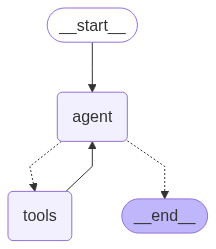

In [18]:
from IPython.display import Image, display
# 그래프 출력
display(Image(agent.get_graph().draw_mermaid_png()))

In [39]:
# 도구 목록
tools = [compensatory_leave_calculator]

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)

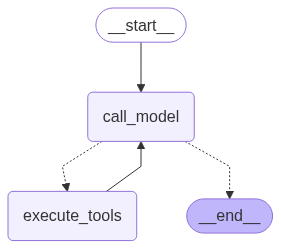

In [43]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver

# 메모리 초기화 
memory = MemorySaver()
# 
# # 체크포인터 지정하여 그래프 컴파일 
# graph_memory = agent.compile(checkpointer=memory)

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=prompt_system_task)
    messages = [system_message] + state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()
# 체크포인터 지정하여 그래프 컴파일 
# graph_memory = builder.compile(checkpointer=memory)

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content=" 주어진 시간으로 보상휴가 시간을 계산해라")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

 주어진 시간으로 보상휴가 시간을 계산해라
================================== Ai Message ==================================

보상 휴가 시간을 계산하기 위해 몇 가지 정보를 더 수집해야 합니다. 다음 항목들에 대해 알려주세요:

1. 월간 평일 총 연장 근무 시간(18시부터 22시 사이, 시/분 단위로).
2. 월간 평일 총 야간 근무 시간(22시부터 다음날 6시 사이, 시/분 단위로).
3. 월간 주말 총 연장 근무 시간(주말 6시부터 22시 사이, 시/분 단위로).
4. 월간 주말 총 야간 근무 시간(주말 22시부터 다음날 6시 사이, 시/분 단위로).

각 항목에 대한 정보를 제공해주시면 계산을 도와드리겠습니다. 만약 어떤 항목을 정리해야 할지 모르겠다면, 제가 도와드릴 수 있습니다!


In [44]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 초기화 
memory = MemorySaver()

# 체크포인터 지정하여 그래프 컴파일 
graph_memory = builder.compile(checkpointer=memory)

In [33]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content=" 알려줘")]
messages = graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

?
================================== Ai Message ==================================

안녕하세요! 보상 휴가 시간 계산을 도와드리겠습니다. 먼저, 몇 가지 정보를 제공해 주시면 됩니다.

1. 월간 평일 총 연장 근무 시간(18시부터 22시 사이, 시/분 단위로)
   
예시: 1시간, 1시간 30분, 20분 등

이 정보를 제공해 주시면 감사하겠습니다! 다른 질문이 있으면 언제든지 말씀해 주세요.
================================ Human Message =================================

 10시간 30분
================================== Ai Message ==================================

감사합니다! 이제 월간 평일 총 연장 근무 시간이 10시간 30분으로 확인되었습니다.

다음으로, 아래 정보를 제공해 주시겠어요?

2. 월간 평일 총 야간 근무 시간(22시부터 다음날 6시 사이, 시/분 단위로)

예시: 1시간, 1시간 30분, 20분 등

이 정보를 주시면 이어서 진행하겠습니다!
================================ Human Message =================================

 10시간 30분
================================== Ai Message ==================================

감사합니다! 월간 평일 총 야간 근무 시간이 10시간 30분으로 확인되었습니다.

이제 세 번째 정보를 부탁드립니다:

3. 월간 주말 총 연장 근무 시간(주말 6시부터 22시 사이, 시/분 단위로)

예시: 1시간, 1시간 30분, 20분 등

이 

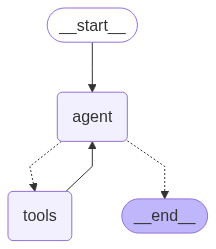

In [64]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# 메모리 초기화 
memory = MemorySaver()

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=[compensatory_leave_calculator],
    state_modifier=prompt_system_task,
    checkpointer=memory,
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
config = {"configurable": {"thread_id": "5"}}
messages = [HumanMessage(content=" 5시간 30분")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

.
================================== Ai Message ==================================

안녕하세요! 보상 휴가 시간 계산을 도와드리겠습니다. 시작하기 위해 몇 가지 정보를 제공해 주셔야 합니다.

첫 번째로, 월간 평일 총 연장 근무 시간을 알려주실 수 있나요? 이 시간은 평일 18시부터 22시 사이에 발생한 총 연장 근무 시간입니다. 시/분 단위로 입력해 주세요. 예를 들어, "1시간", "1시간 30분", "20분" 등으로 말씀해 주시면 됩니다. 

답변이 어려우시면 언제든지 도와드리겠습니다!
================================ Human Message =================================

 20시간
================================== Ai Message ==================================

감사합니다! 월간 평일 총 연장 근무 시간을 20시간으로 확인했습니다.

다음으로, 월간 평일 총 야간 근무 시간을 알려주실 수 있을까요? 이 시간은 평일 22시부터 다음날 6시 사이에 발생한 총 야간 근무 시간입니다. 시/분 단위로 입력해 주세요. 예를 들어, "1시간", "1시간 30분", "20분" 등으로 말씀해 주시면 됩니다. 

도움이 필요하시면 말씀해 주세요!
================================ Human Message =================================

 2시간
================================== Ai Message ==================================

감사합니다! 월간 평일 총 야간 근무 시간을 2시간으로 확인했습니다.

이제 세 번째 정보입니다.

In [59]:
config = {"configurable": {"thread_id": "5시간이요"}}
messages = [HumanMessage(content="네")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

네
================================== Ai Message ==================================

안녕하세요! 보상 휴가 시간을 계산하기 위해 필요한 정보를 제공해 주시면 도와드리겠습니다. 아래의 정보를 단계별로 알려주시면 됩니다.

1. 월간 평일 총 연장 근무 시간 (평일 18시부터 22시 사이의 총 근무 시간, 예: 1시간, 1시간 30분, 20분 등)
   
이 정보를 먼저 알려주실 수 있나요?


In [54]:
import gradio as gr
from typing import List, Tuple
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

# 메모리 사용 준비
# memory = MemorySaver()
# graph_memory = builder.compile(checkpointer=memory)

# 예시 질문들
example_questions = [
    "하이~ 시작해 볼까?",
    # "오늘의 스페셜 메뉴는 무엇인가요?",
    # "파스타에 어울리는 음료는 무엇인가요?"
]

# 답변 메시지 처리를 위한 함수
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        config = {"configurable": {"thread_id": thread_id}}
        inputs = {"messages": [HumanMessage(content=message)]}
        
        result = graph.invoke(inputs, config=config)
        
        if "messages" in result:
            # 메시지 로깅 (선택사항)
            print(f"스레드 ID: {thread_id}")
            for msg in result["messages"]:
                msg.pretty_print()

            last_message = result["messages"][-1]
            if isinstance(last_message, AIMessage):
                return last_message.content

        return "응답을 생성하지 못했습니다."

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."


# 챗봇 클래스 생성
class ChatBot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        print(f"Thread ID: {self.thread_id}")
        response = process_message(message, history, self.thread_id)
        return response

chatbot = ChatBot()


# ChatInterface 생성
demo = gr.ChatInterface(
    fn=chatbot.chat,
    title="보상휴가 계산 AI 어시스턴트",
    description="입력하신 근무시간을 기준으로 발생 가능한 보상휴가 시간을 계산해 드립니다.",
    examples=example_questions,
    # verbose=True,
    theme=gr.themes.Soft()
)

# Gradio 앱 실행
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [52]:
demo.close()

Closing server running on port: 7860
